# Bootstrap comparisons

**Goal:** In the `Deep-Ensembles` nb, I started testing out which of our stochastic knobs were leading to the most variation, so now I'm going to try to get together some of the message plots for comparing the different models.

**Table of Contents**
1. Ways of constructing the IQR
    - Whether it's necessary to construct the $m_{hh}$ histogram before getting the IQR / standard deviation?
    - How many samples are necessary from each $(m_{h1},m_{h2})$ for constructing a stable IQR
    - It would be interesting to try to probe the stability of the error bars w/r.t. how many model trainings I'm including
2. Overlaying error bars for different model trainings
3. Comparing $\beta$ choices for R-NVP models
4. Other options(?)
    - Whether random splits for p = 0.1 captures the full uncertainty for various splits?
    - Interpolation constraint
    - lr


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare
from scipy.stats import norm 
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text

import torch
from torch import nn
from torch.distributions import Normal, Categorical,OneHotCategorical

os.sys.path.append('../Flow-Models')
from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


In [2]:
prodTag = 'FEB20'
ntag = 2
subDir = 'data16_PFlow-FEB20-5jets'
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'

nSeeds = 250
varTag = 'HH vars'

## 1. Ways of constructing the IQR

### Is it necessary to first make the $m_{hh}$ histograms and *then* get the IQR?

In [5]:
H_dict = {
    'HH vars': 16,
    'HC vars': 32
}

col_dict = {
    'HH vars': ['log_m_hh_cor2','absCosThetaStar'],
    'HC vars': ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh']
}

In [31]:
ms5varDict = {}

lr = .001
L, H = 5, H_dict[varTag]
i = 0

cols = col_dict[varTag]
colTag = '_'.join(cols)

ps = [0.01, 0.1]
betas = [1e-6,1e-3]

for p in [0.01]:
    
    tag = f'_SM_2b_p_{p}'
    configDir = f'data16_PFlow-FEB20-5jets{tag}_2b_detaCut'
  
    for beta in [0.001]: #betas:

        rnvpDir = f'rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter{i}'

        for seed in range(nSeeds):

            seedTag = f'_seed{seed}' if seed != 10 else ''
            filename = f'../Flow-Models/models/{configDir}{seedTag}/{rnvpDir}/loss_acc.json'
            if os.path.exists(filename):

                with open(filename, 'r') as varfile:
                    metrics = json.load(varfile)
                ms5varDict[f'p_{p}_beta{beta:.0e}_seed{seed}'] = {k: np.array(v) for k,v in metrics.items()}

            else:
                print(filename,'does not exist')

In [9]:
SR_loss,VR_loss = {}, {}

for p, beta in product(ps,betas):
    
    key = f'p_{p}_beta{beta:.0e}'

    SR_loss[key] = np.zeros(nSeeds)
    VR_loss[key] = np.zeros(nSeeds)

    for seed in range(nSeeds):
        SR_loss[key][seed] = ms5varDict[f'{key}_seed{seed}']['SR_loss'][-22]
        VR_loss[key][seed] = ms5varDict[f'{key}_seed{seed}']['val_loss'][-22]


KeyError: 'p_0.01_beta1e-06_seed100'

In [10]:
betaStr = r'$\beta$'

In [11]:
title = f'R-NVP {len(cols)} vars: L={L}, H={H}, lr={lr}'

In [81]:
tag

'_SM_2b_p_0.01'

In [13]:
ls, lc = [], []

eps = .003
marker_size = 20

for p, colors in zip(ps, [['deepskyblue','navy'],['crimson','darkred']]):

    for beta, c, m in zip(betas,colors,['o','s']):

        key = f'p_{p}_beta{beta:.0e}'
        vr,sr = VR_loss[key],SR_loss[key]

        plt.scatter(vr,sr,marker_size,color=c,label=f'p={p}, {betaStr}={beta:.0e}',marker=m)

        reg = LinearRegression().fit(vr.reshape(-1, 1),sr)
        m, b = reg.coef_,reg.intercept_
        xx = plt.xlim()
        plt.plot(xx, m*xx+b,color=c,ls='--')
    
        R, prob = pearsonr(vr,sr)
        ls.append(f'R = {R:1.2f}')
        lc.append(c)
    
        print(f'{key}:')
        print(f'   y = {m[0]:.2f} x + {b:.2f}')
        print(f'   R = {R:.2f}, p = {prob:.2e}')
    
plt.xlabel('validation loss',fontsize=15)
plt.ylabel('SR loss',fontsize=15)
plt.legend(loc='lower right',fontsize=11)

ax = plt.gca()
xmin, ymax = plt.xlim()[0], plt.ylim()[1]
rainbow_text(xmin+eps,ymax-eps,ls,lc,ax=ax,ha='left',va='top', yoffset=1.2,fontsize=14)

plt.title(title,fontsize=15,loc='left')

# figDir_p01 = f'figures/{subDir}_SM_2b_p_0.01_2b_detaCut/rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter0/'
# plt.savefig(f'{figDir_p01}SR_loss_vs_val_loss_vary_p_beta.pdf',bbox_inches='tight')

plt.show()

p_0.01_beta1e-06:
   y = 1.06 x + 0.00
   R = 1.00, p = 0.00e+00


KeyError: 'p_0.01_beta1e-03'

Wow - I found this *fascinating* that the $\beta$ helped so much for the p = 0.01 case, and it almost looks like it's a constant shift of .4 between two values

0.006207351684570313 0.016783293160319734
-0.00918889045715332 0.01718837628771294


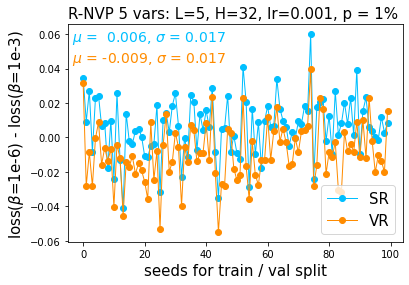

In [9]:
ls, lc = [], []

for loss, label, c in zip([SR_loss,VR_loss],['SR','VR'],['deepskyblue','darkorange']):

    yy = loss['p_0.01_beta1e-06']-loss['p_0.01_beta1e-03']

    plt.plot(yy,color=c,label=label,marker='o',linewidth=1)

    mu, sigma = np.mean(yy), np.std(yy)
    print(mu,sigma)
    
    ls.append(f'$\mu$ = {mu: .3f}, $\sigma$ = {sigma:.3f}')
    lc.append(c)
    
plt.xlabel('seeds for train / val split',fontsize=15)
plt.ylabel(f'loss({betaStr}=1e-6) - loss({betaStr}=1e-3) ',fontsize=15)
plt.legend(loc='lower right',fontsize=15)

ax = plt.gca()
xmin, ymax = plt.xlim()[0], plt.ylim()[1]
rainbow_text(xmin+eps,ymax-eps,ls,lc,ax=ax,ha='left',va='top', yoffset=1.2,fontsize=14)

plt.title(title+f', p = 1%',fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}SR_loss_and_val_loss_betaDelta_{nSeeds}seeds.pdf',bbox_inches='tight')
plt.show()

-0.016826467514038088 0.0076865289257392585
-0.016193552017211912 0.0064922684518099434


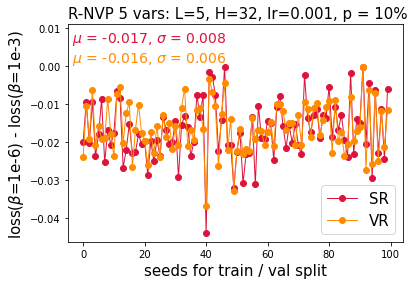

In [10]:
ls, lc = [], []

for loss, label, c in zip([SR_loss,VR_loss],['SR','VR'],['crimson','darkorange']):

    yy = loss['p_0.1_beta1e-06']-loss['p_0.1_beta1e-03']

    plt.plot(yy,color=c,label=label,marker='o',linewidth=1)

    mu, sigma = np.mean(yy), np.std(yy)
    print(mu,sigma)
    
    ls.append(f'$\mu$ = {mu: .3f}, $\sigma$ = {sigma:.3f}')
    lc.append(c)
    
plt.xlabel('seeds for train / val split',fontsize=15)
plt.ylabel(f'loss({betaStr}=1e-6) - loss({betaStr}=1e-3) ',fontsize=15)
plt.legend(loc='lower right',fontsize=15)

ax = plt.gca()
xmin, ymax = plt.xlim()[0], plt.ylim()[1]
rainbow_text(xmin+eps,ymax+2.5*eps,ls,lc,ax=ax,ha='left',va='top', yoffset=1.2,fontsize=14)
plt.ylim(plt.ylim()[0],ymax+3*eps)

plt.title(title+f', p = 10%',fontsize=15,loc='left')

figDir_p1 = f'figures/{subDir}_SM_2b_p_0.1_2b_detaCut/rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter0/'
plt.savefig(f'{figDir_p1}SR_loss_and_val_loss_betaDelta_{nSeeds}seeds.pdf',bbox_inches='tight')
plt.show()

So for this one, it seems like the offset is larger than the deviation, but I this makes sense, b/c I was seeing a much tighter correlation b/w the VR and SR loss for p = 10%.

In [11]:
ls, lc = [], []

for p, c in zip(ps,['deepskyblue','crimson']):

    xx = VR_loss[f'p_{p}_beta1e-06']-VR_loss[f'p_{p}_beta1e-03']
    yy = SR_loss[f'p_{p}_beta1e-06']-SR_loss[f'p_{p}_beta1e-03']

    plt.scatter(xx,yy,color=c,label=f'p = {p*100:.0f}%')
    
    R, prob = pearsonr(xx,yy)
    ls.append(f'R = {R:1.2f}')
    lc.append(c)
    
plt.xlabel(f'VR loss({betaStr}=1e-6 - {betaStr}=1e-3)',fontsize=15)
plt.ylabel(f'SR loss({betaStr}=1e-6 - {betaStr}=1e-3)',fontsize=15)
plt.legend(loc='lower right',fontsize=15)

ax = plt.gca()
xmin, ymax = plt.xlim()[0], plt.ylim()[1]
rainbow_text(xmin+eps,ymax-2*eps,ls,lc,ax=ax,ha='left',va='top', yoffset=1.5,fontsize=15)

plt.title(title,fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}SR_loss_vs_val_loss_betaDelta_{nSeeds}seeds.pdf',bbox_inches='tight')

plt.show()

**Summary:** So I was interested in this interplay b/w p and $\beta$, and these are some good metrics for the intuition that I've been building up that larger $\beta$ are better for p = 0.01 and lower $\beta$ for p = 0.1. 

So I'll use this as a *starting point* for these $m_{hh}$ systematics plots that I'm about to look at now :-)

**Back to what I was originally trying to do:** look at the difference between getting the variation of 100 histograms and then the IQR vs just putting all the histograms together and looking at the error band in each bin.

Since it's a little easier to deal with the p = 1% stats, I'll start off with this data sample.


In [33]:
color_list = [
    ['skyblue','deepskyblue','blue'],
    ['bisque','gold','darkorange'],
    ['lightgreen','limegreen','green'],
    ['coral','orangered','red']
]

In [32]:
text = "$\mathbf{ATLAS}$ data Internal\n"
text += "2016 data FEB2020 MNT prod\n"
text += "DL1r 77% WP, pairAGraph w/ $|\Delta \eta_{hh}|$ < 1.5"

In [104]:
reload=False

p, beta = .01, 1e-3
nb,r = 50,(250,1250)

nPreds = 10
r5Seeds_hists    = {}
r5Seeds_hists_cs = {}

# Get the data
tag = f'_SM_2b_p_{p}'
di = data(5, 16, prodTag, tag, ntag, s)

mi = (di.df.abs_deta_hh < 1.5)
di.mlPrepare(mi, cols, N=-1)
df = di.df
SR = (df.kinematic_region==0) & mi
nSeeds = 250

nEvts = di.X_SR.shape[0]

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


In [112]:
assert (varTag=='HH vars') or (varTag == 'HC vars')

for seed in tqdm(range(nSeeds)):

    # Load in the R-NVP
    seedTag = f'_seed{seed}' if seed != 10 else ''
    ri = RealNVP(f'{subDir}{tag}_2b_detaCut{seedTag}', lr, beta, cols, 0, L, H,
                 load_model=True,modelBaseDir='../Flow-Models/models',debug=False)
    filename = f'{ri.modelDir}/df_SR.h5'
    key = f'p_{p}_beta{beta:.0e}_seed{seed}'
    
    if reload:
        rpi = RealNVP_Plots(ri, save=False)

        if varTag == 'HH vars':
            dfi = rpi.medianMarginals(di.X_SR, di.Y_SR, di, nPreds=nPreds, plot=False)
        
        else:
            dfi = rpi.pred_hh(di.X_SR, di.Y_SR, di.scalar, SR, df, nPreds=nPreds, cols=cols, plot=False)
        
        
        # Swap levels and save the seed
        dfi = dfi.swaplevel()
        idx = pd.MultiIndex.from_product([range(nEvts),[seed],range(nPreds)],
                                         names=['events','seeds','samples'])
        dfi.index = idx
        
        dfi.to_hdf(filename,key='df',format='table')
    else:
        dfi = pd.read_hdf(filename,key='df')
        
    ni,_ = np.histogram(dfi.m_hh_cor2, nb, r, weights=np.ones_like(dfi.m_hh_cor2)/nPreds)
    r5Seeds_hists[key] = ni
    
    # And now w/ |cos(theta*)|
    ni,_ = np.histogram(dfi.absCosThetaStar, nb, (-0.05,1.05), weights=np.ones_like(dfi.absCosThetaStar)/nPreds)
    r5Seeds_hists_cs[key] = ni
    
# 2b
n_2b,e = np.histogram(df.loc[SR,'m_hh_cor2'],nb,r) 
r5Seeds_hists[f'p_{p}_2b'] = n_2b

n_2b_cs,f = np.histogram(df.loc[SR,'absCosThetaStar'],nb,(-0.05,1.05)) 
r5Seeds_hists_cs[f'p_{p}_2b'] = n_2b_cs

100%|██████████| 250/250 [00:40<00:00,  6.21it/s]


For starters - let's try just reading in the first 10 files into a dask df.

In [106]:
glob_filename = f'../Flow-Models/models/{subDir}{tag}_2b_detaCut*/'
glob_filename+= f'rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter{i}/df_SR.h5'

In [37]:
assert len(glob(glob_filename)) == nSeeds
len(glob(glob_filename))

250

In [38]:
df_SR = dd.read_hdf(glob_filename, 'df', mode='r')

In [39]:
df_SR.head()

m_h1        m_h2  log_m_hh_cor2  absCosThetaStar  \
events seeds samples                                                           
0      10    0        130.948105  101.560234       4.304483         0.293898   
             1        129.099579  107.476463       6.039802         0.473571   
             2        123.367012  116.775215       5.027071         0.823058   
             3        112.333488  111.663887       4.037289         1.060145   
             4        130.961731  125.690796       5.157409         0.215038   

                       m_hh_cor2  
events seeds samples              
0      10    0        324.030927  
             1        669.809735  
             2        402.485727  
             3        306.672503  
             4        423.713730

In [20]:
df_SR._meta

Empty DataFrame
Columns: [m_h1, m_h2, log_pT_h1, log_pT_h2, eta_h2, eta_h1, log_dphi_hh, pT_h1, pT_h2, dphi_hh, m_hh, m_hh_cor2, absCosThetaStar, pt_hh]
Index: []

In [21]:
df_SR.npartitions

250

In [180]:
# df_SR.divisions

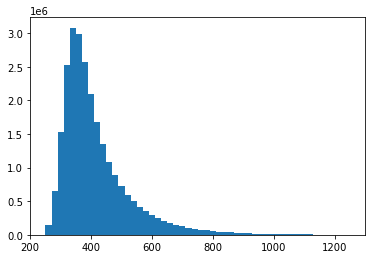

In [40]:
plt.hist(df_SR.m_hh_cor2.compute().values,nb,r)
plt.show()

In [41]:
m_hh = df_SR.m_hh_cor2.compute().values.reshape(-1,nEvts)
mhh_med  = np.median(m_hh,axis=0)
mhh_mean = np.mean(m_hh,axis=0)
mhh_std = np.std(m_hh,axis=0)

In [28]:
m_h1 = df_SR.m_h1.compute().values.reshape(-1,nEvts)
np.unique(m_h1,return_counts=True)

(array([103.55291748, 103.55466461, 103.60970306, ..., 142.68254089,
        142.76130676, 142.76959229]),
 array([2500, 2500, 2500, ..., 2500, 2500, 2500]))

In [35]:
# med = np.median(df_SR.m_hh_cor2.compute().values.reshapnSeedsnS,nEvts,nPreds),axis=[0,2])

In [36]:
# med = np.median(df_SR.m_hh_cor2.compute().values.reshape(10,nEvts,nPreds),axis=[0,2])

In [37]:
# plt.hist(mhh_med,nb,r,color='blue',histtype='step',lw=2,label='event level median')
# plt.hist(mhh_mean,nb,r,color='orange',histtype='step',lw=2,label='event level mean')
# plt.xlabel('$m_{hh}^{cor,2}$',fontsize=15)
# plt.ylabel('Entries',fontsize=15)
# plt.legend(loc='upper right',fontsize=12)
# plt.title('HC vars',loc='right',fontsize=15)

# ax = plt.gca()
# plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

# evtText = f'Aggregation over 10 seeds and {nPreds}\n'
# evtText+= 'for each $(m_{h1},m_{h2})$ evt in the SR\n\n'
# evtText+= f'{p*100:1.0f}% of 2b stats, {betaStr}={beta:1.0e}'

# plt.text(.95,.65,evtText,ha='right',va='top',transform=ax.transAxes,fontsize=12)

# plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_10seeds_evtLevelMedMean.pdf', bbox_inches='tight')

# plt.show()

In [42]:
for p in ps:
    
    hists = np.vstack([r5Seeds_hists[f'p_{p}_beta{beta:.0e}_seed{s}'] for s in range(nSeeds) 
                       if f'p_{p}_beta{beta:.0e}_seed{s}' in r5Seeds_hists.keys()])
    
    r5Seeds_hists[f'p_{p}_beta{beta:.0e}_median'] = np.median(hists,axis=0)
    r5Seeds_hists[f'p_{p}_beta{beta:.0e}_mean']   =   np.mean(hists,axis=0)
   
    break

In [44]:
figDir_p01 = f'figures/{subDir}_SM_2b_p_0.01_2b_detaCut/rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter0/'

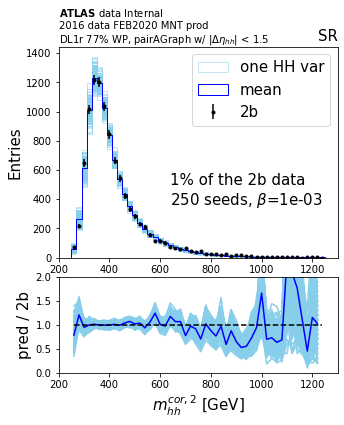

In [46]:
for aggregator in ['median','mean']:

    p,colors = 0.01, color_list[0]
    xx = 0.5*(e[1:]+e[:-1])

    # Make the figure
    fig = plt.figure(figsize=(11,6))
    gs = gridspec.GridSpec(3,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

    # Put 2b on the plot
    n_2b = r5Seeds_hists[f'p_{p}_2b']
    ax1.errorbar(xx, n_2b, np.sqrt(n_2b), label='2b', fmt='.', color='k')
    m = (n_2b!=0)

    # Loop over the iterations
    for seed in range(nSeeds):
        ni = r5Seeds_hists[f'p_{p}_beta{beta:.0e}_seed{seed}']
        l = f'one {varTag[:-1]}' if seed==0 else ''
        ax1.hist(xx,nb,r,color=colors[0],histtype='step',weights=ni,label=l,alpha=0.5)
        ax2.plot(xx[m], ni[m]/n_2b[m], color=colors[0])

    nj = r5Seeds_hists[f'p_{p}_beta{beta:.0e}_{aggregator}']
    ax1.hist(xx,nb,r,color=colors[-1],histtype='step',weights=nj,label=aggregator)
    ax2.plot(xx[m], nj[m]/n_2b[m], color=colors[-1])

    ax1.set_ylabel('Entries',fontsize=15)
    ax1.legend(fontsize=15)
    ax1.set_title('SR',loc='right',fontsize=15)

    ax2.plot(xx, np.ones_like(xx), 'k--')
    ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]', fontsize=15)
    ax2.set_ylim(0,2)
    ax2.set_ylabel('pred / 2b',fontsize=15)

    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
    ax1.text(0.4, 0.4, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}',
             ha='left',va='top',transform=ax1.transAxes,fontsize=15)

    plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_{nSeeds}seeds_{aggregator}.pdf', bbox_inches='tight')

    plt.show()

Ok, but my first take away message here, is I think this actually looks pretty great lol.

**Next:** How would these change if instead I looked at the event level median or mean?
- For the mean, these would be the same
- For the median, *not necessarily*

Let's look at the log scale!

In [47]:
glob_filename = f'../Flow-Models/models/{subDir}{tag}_2b_detaCut*/'
glob_filename+= f'rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter{i}/df_SR.h5'

ddf = dd.read_hdf(glob_filename,key='df')

In [43]:
assert len(glob(glob_filename))==250

In [48]:
df0 = ddf[['m_hh_cor2','absCosThetaStar']].compute()

**Step 1:** J sanity check that it doesn't matter when I compute this average.

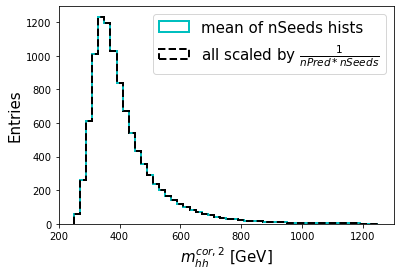

In [49]:
nom = np.histogram(df0.m_hh_cor2,nb,r)[0]/(nSeeds*nPreds)
plt.hist(xx,nb,r,histtype='step',weights=nj,lw=2,color='c',
         label='mean of nSeeds hists')
plt.hist(xx,nb,r,histtype='step',weights=nom,ls='--',lw=2,color='k',
         label=r'all scaled by $\frac{1}{nPred*nSeeds}$')
plt.legend(loc='upper right',fontsize=15)
plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel('Entries',fontsize=15)

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_{nSeeds}seeds_{aggregator}_cfEvtLevel.pdf', bbox_inches='tight')
plt.show()

In [46]:
df0[2000000:2000020]

m_hh_cor2  absCosThetaStar
events seeds samples                             
9221   115   0        343.696045         0.447487
             1        324.528815         0.431060
             2        704.416263         0.346005
             3        356.856945         0.353386
             4        383.817291         0.222164
             5        346.696343         0.055065
             6        510.921260         0.647577
             7        675.769922         0.054379
             8        317.398563         0.725537
             9        379.415272         0.195755
9222   115   0        471.095857         0.602905
             1        418.430020         0.118017
             2        669.244772         0.036084
             3        375.328598         0.035179
             4        304.658440         0.551610
             5        364.809553         0.556859
             6        318.076579         0.141198
             7        390.376990         0.210843
             8        365.258692         0.504121
             9        377.872024         0.644514

In [47]:
# df0[2000000:2000020]

In [50]:
df0.tail()

m_hh_cor2  absCosThetaStar
events seeds samples                             
10040  99    5        369.504644         0.096345
             6        404.676018         0.434637
             7        337.372827         0.544868
             8        374.340088         0.228076
             9        438.478352         0.228327

In [49]:
df0.loc(axis=0)[:,range(100,200)].m_hh_cor2

events  seeds  samples
0       100    0          836.517511
               1          394.444645
               2          382.569162
               3          393.277500
               4          396.491147
                             ...    
10040   199    5          391.455091
               6          315.981302
               7          323.458898
               8          297.284629
               9          354.509623
Name: m_hh_cor2, Length: 10041000, dtype: float64

In [51]:
# Note - I need to reshape this way b/c df0 was created from a dask df, so the first axis should
# be the partitions, i.e, the seeds.
mhh_all = df0['m_hh_cor2'].values.reshape(nSeeds,-1,nPreds)

In [50]:
# I wasn't sure if this was working
# n0,_ = np.histogram(df0.loc(axis=0)[:,range(100)].m_hh_cor2.values,nb,r)
# n1,_ = np.histogram(df0.loc(axis=0)[:,range(100,200)].m_hh_cor2.values,nb,r)

In [312]:
# I think this would also work, but it was hard to get a 1-1 correspondence with the df0 index
# n0 = np.histogram(mhh_all[:100].flatten(),nb,r)[0]
# n1 = np.histogram(mhh_all[100:200].flatten(),nb,r)[0]

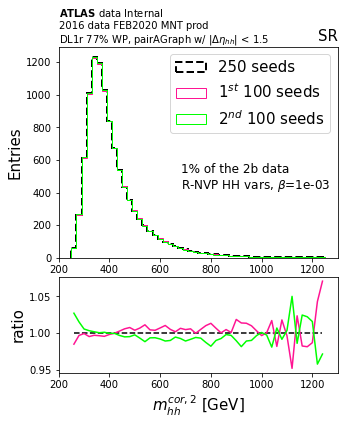

In [53]:
# Make the figure
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

ax1.hist(xx,nb,r,histtype='step',weights=nom,ls='--',lw=2,color='k',label='250 seeds')

n0 = np.mean(hists[:100],axis=0)
n1 = np.mean(hists[100:200],axis=0)

N0,_,_ = ax1.hist(xx,nb,r,weights=n0,histtype='step',color='deeppink',label='$1^{st}$ 100 seeds')
N1,_,_  = ax1.hist(xx,nb,r,weights=n1,histtype='step',color='lime',label='$2^{nd}$ 100 seeds')

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.plot(xx,n0/nj,color='deeppink')
ax2.plot(xx,n1/nj,color='lime')

ax1.legend(loc='upper right',fontsize=15)
ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
ax1.set_ylabel('Entries',fontsize=15)
ax2.set_ylabel('ratio',fontsize=15)

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
ax1.set_title('SR',loc='right',fontsize=15)
ax1.text(0.44, 0.45, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax1.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_250_vs_100seeds_mean.pdf', bbox_inches='tight')
plt.show()

Take away: 250 seeds as opposed to 100 is really helping esp with the variation in the *tails*.

In [54]:
# Make the figure
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

ax1.hist(xx,nb,r,histtype='step',weights=nom,ls='--',lw=2,color='k',label='250 seeds')

n0 = np.mean(hists[:50],axis=0)
n1 = np.mean(hists[50:100],axis=0)
n2 = np.mean(hists[100:150],axis=0)
n3 = np.mean(hists[150:200],axis=0)
n4 = np.mean(hists[200:],axis=0)

ax1.hist(xx,nb,r,weights=n0,histtype='step',color='deeppink',label='$1^{st}$ 50 seeds')
ax1.hist(xx,nb,r,weights=n1,histtype='step',color='deeppink',label='$2^{nd}$ 50 seeds',ls='--')
ax1.hist(xx,nb,r,weights=n2,histtype='step',color='lime',label='$3^{rd}$ 50 seeds')
ax1.hist(xx,nb,r,weights=n3,histtype='step',color='lime',label='$4^{th}$ 50 seeds',ls='--')
ax1.hist(xx,nb,r,weights=n4,histtype='step',color='orange',label='$5^{th}$ 50 seeds')

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.plot(xx,n0/nj,color='deeppink')
ax2.plot(xx,n1/nj,color='deeppink',ls='--')
ax2.plot(xx,n2/nj,color='lime')
ax2.plot(xx,n3/nj,color='lime',ls='--')
ax2.plot(xx,n4/nj,color='orange')

ax1.legend(loc='upper right',fontsize=15)
ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
ax1.set_ylabel('Entries',fontsize=15)
ax2.set_ylabel('ratio',fontsize=15)

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
ax1.set_title('SR',loc='right',fontsize=15)
ax1.text(0.44, 0.2, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax1.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_250_vs_50seeds_mean.pdf', bbox_inches='tight')
plt.show()

**Next:** Compare the # of predictions needed, or try out 5 vs 10

In [55]:
n_1pred,_ = np.histogram(df0.loc(axis=0)[:,:,0].m_hh_cor2.values,nb,r)

mhh_5samples = np.concatenate([df0.loc(axis=0)[:,:,i].m_hh_cor2.values for i in range(5)])
n_5pred,_ = np.histogram(mhh_5samples,nb,r)

In [56]:
# Make the figure
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

ax1.hist(xx,nb,r,weights=n_1pred/nSeeds,histtype='step',color='hotpink',label='250 seeds, 1 preds')
ax1.hist(xx,nb,r,weights=n_5pred/(nSeeds*5),histtype='step',color='lightseagreen',label='250 seeds, 5 preds')
ax1.hist(xx,nb,r,histtype='step',weights=nom,ls='--',lw=2,color='k',label='250 seeds, 10 preds')

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.plot(xx,n_1pred/(nSeeds*nj),color='hotpink')
ax2.plot(xx,n_5pred/(nSeeds*5*nj),color='lightseagreen')

ax1.legend(loc='upper right',fontsize=15)
ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
ax1.set_ylabel('Entries',fontsize=15)
ax2.set_ylabel('ratio',fontsize=15)

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
ax1.set_title('SR',loc='right',fontsize=15)
ax1.text(0.44, 0.45, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax1.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_250seeds_1_5_10preds_mean.pdf', bbox_inches='tight')
plt.show()

From here - maybe 5 samples are fine - but I'll wait to see what the standard deviation over histograms looks like.

Ok - so the light blue lines on the plot above is like the 100% IQR, but I think I actully want the 50% or 68.5% IQRs.

In [57]:
iqr_p01 = iqr(hists,axis=0)

p_16,p_84 = np.percentile(hists,[50-34.14,50+34.14],axis=0)
perc_1sig = p_84-p_16

hist_1sig = np.std(hists,axis=0)

iqr_p01.shape

(50,)

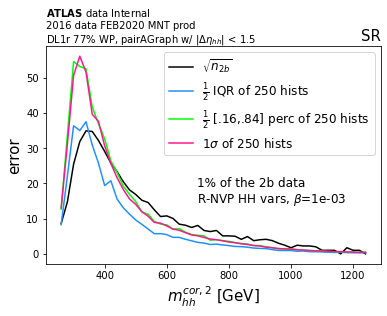

In [58]:
plt.plot(xx,np.sqrt(n_2b),'k',label=r'$\sqrt{n_{2b}}$')

plt.plot(xx,iqr_p01/2,'dodgerblue',label=r'$\frac{1}{2}$ IQR'+f' of {nSeeds} hists')
plt.plot(xx,perc_1sig/2,'lime',label=r'$\frac{1}{2}$ [.16,.84] perc'+f' of {nSeeds} hists')
plt.plot(xx,hist_1sig,color='deeppink',label=f'$1 \sigma$ of {nSeeds} hists')


plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel('error',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(loc='upper right',fontsize=12)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.45, 0.4, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/errs_m_hh_cor2_SR.pdf', bbox_inches='tight')
plt.show()

I think this is pretty interesting that
1. Above 600 GeV $\sqrt{n_{2b}}$ and IQR are the same
2. The standard dev is *smaller* than the IQR... *why*?
3. The $1\sigma$ IQR is so much larger

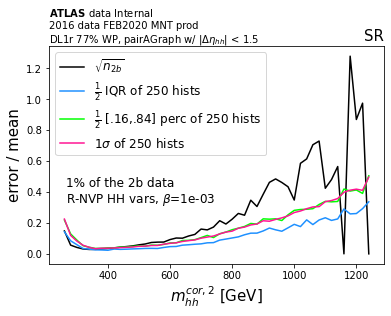

In [59]:
plt.plot(xx,np.sqrt(n_2b)/nj,'k',label=r'$\sqrt{n_{2b}}$')

plt.plot(xx,iqr_p01/(2*nj),'dodgerblue',label=r'$\frac{1}{2}$ IQR'+f' of {nSeeds} hists')
plt.plot(xx,perc_1sig/(2*nj),'lime',label=r'$\frac{1}{2}$ [.16,.84] perc'+f' of {nSeeds} hists')
plt.plot(xx,hist_1sig/nj,color='deeppink',label=f'$1 \sigma$ of {nSeeds} hists')

plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel('error / mean',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(loc='upper left',fontsize=12)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.05, 0.4, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/relErrs_m_hh_cor2_SR.pdf', bbox_inches='tight')
plt.show()

**Next:** Let's look at the bin-by-bin "fancy" significance formula and c.f. the options I have for defining the error here.

In [60]:
def significance(n,b,db):
    '''
    Implments (1) from ATL-COM-GEN-2018-026
    '''
    
    z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
    z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
    z2 *= 2
    
    return np.sign(n-b) * np.sqrt(z2)

So, $1\sigma$ is a *more conservative* measure here.

In [63]:
z = significance(n_2b,nom,hist_1sig)

plt.hist(z,10,(-3,3),density=True,color='deeppink')
mu,std = np.mean(z),np.std(z)

xi = np.linspace(-3,3)
zi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
plt.plot(xi,zi,'k--')

_, ymax = plt.ylim()
plt.ylim(0,1.2*ymax)

ax = plt.gca()
ti = f'$\mu$ = {mu:.2f},$\sigma$ = {std:.2f}\n'
ti+= 'bkg err: std dev of preds'
plt.text(.025,.95,ti,transform=ax.transAxes,
         ha='left',va='top',fontsize=12)

plt.xlabel('significance',fontsize=15)
plt.ylabel('entries',fontsize=15)
plt.title(f'R-NVP with {varTag}, 1% of 2b data in SR',fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}/signficance_1sigma_m_hh_cor2_SR.pdf', bbox_inches='tight')

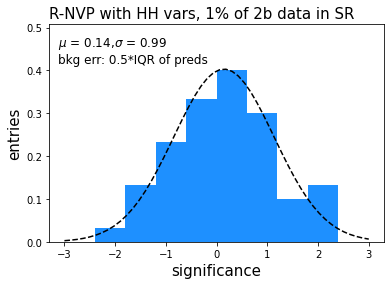

In [64]:
z = significance(n_2b,nom,0.5*iqr_p01)

plt.hist(z,10,(-3,3),density=True,color='dodgerblue')
mu,std = np.mean(z),np.std(z)

xi = np.linspace(-3,3)
zi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
plt.plot(xi,zi,'k--')

_, ymax = plt.ylim()
plt.ylim(0,1.2*ymax)

ax = plt.gca()
ti = f'$\mu$ = {mu:.2f},$\sigma$ = {std:.2f}\n'
ti+= 'bkg err: 0.5*IQR of preds'
plt.text(.025,.95,ti,transform=ax.transAxes,
         ha='left',va='top',fontsize=12)

plt.xlabel('significance',fontsize=15)
plt.ylabel('entries',fontsize=15)
plt.title(f'R-NVP with {varTag}, 1% of 2b data in SR',fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}/signficance_iqr_m_hh_cor2_SR.pdf', bbox_inches='tight')

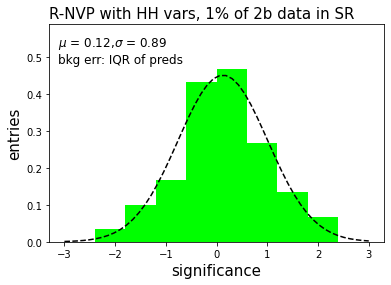

In [65]:
z = significance(n_2b,nom,0.5*perc_1sig)

plt.hist(z,10,(-3,3),density=True,color='lime')
mu,std = np.mean(z),np.std(z)

xi = np.linspace(-3,3)
zi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
plt.plot(xi,zi,'k--')

_, ymax = plt.ylim()
plt.ylim(0,1.2*ymax)

ax = plt.gca()
ti = f'$\mu$ = {mu:.2f},$\sigma$ = {std:.2f}\n'
ti+= 'bkg err: IQR of preds'
plt.text(.025,.95,ti,transform=ax.transAxes,
         ha='left',va='top',fontsize=12)

plt.xlabel('significance',fontsize=15)
plt.ylabel('entries',fontsize=15)
plt.title(f'R-NVP with {varTag}, 1% of 2b data in SR',fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}/signficance_1sig_perc_m_hh_cor2_SR.pdf', bbox_inches='tight')

### How many samples are necessary from each $(m_{h1},m_{h2})$ for constructing a stable IQR?

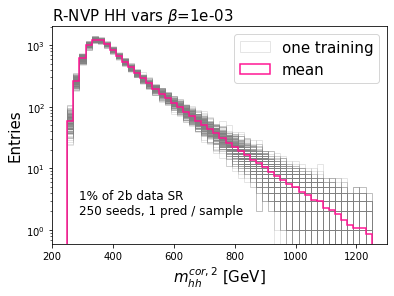

In [68]:
hs_1pred = np.zeros((nSeeds,nb))

for log,logTag,xloc,yloc in zip([False,True],['','_log'],[.4,.08],[.55,.25]):

    plt.figure()
    for i in range(nSeeds):
        l = 'one training' if i == 0 else ''
        pi,_,_ = plt.hist(mhh_all[i,:,0],nb,r,color='grey',histtype='step',alpha=0.2,label=l,log=log)
        hs_1pred[i] = pi
        
    nom_1pred = plt.hist(mhh_all[:,:,0].flatten(),nb,r,color='deeppink',histtype='step',lw=1.5,
                         label='mean',weights=np.ones_like(mhh_all[:,:,0].flatten())/nSeeds,log=log)[0]

    plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
    plt.ylabel('Entries',fontsize=15)
    plt.legend(fontsize=15)
    plt.title(f'R-NVP {varTag} {betaStr}={beta:.0e}',fontsize=15,loc='left')
    ax = plt.gca()
    plt.text(xloc,yloc,'1% of 2b data SR\n250 seeds, 1 pred / sample',
             ha='left',va='top',transform=ax.transAxes,fontsize=12)

    plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_250seeds_1preds_fluctuations{logTag}.pdf',bbox_inches='tight')
    plt.show()

Ok - seems legit.

In [257]:
mhh_all.shape

(250, 10041, 10)

In [69]:
std_1pred = np.std(hs_1pred,axis=0)
iqr_1pred = iqr(hs_1pred,axis=0)

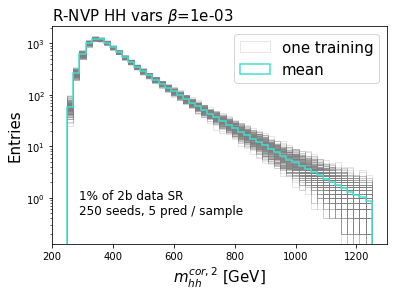

In [70]:
# Sanity check the m_hh reshaping code 
hs_5pred = np.zeros((nSeeds,nb))

for log,logTag,xloc,yloc in zip([False,True],['','_log'],[.4,.08],[.55,.25]):

    plt.figure()
    for i in range(nSeeds):
        l = 'one training' if i == 0 else ''
        pi,_,_ = plt.hist(mhh_all[i,:,:5].flatten(),nb,r,color='grey',histtype='step',alpha=0.2,
                         weights=np.ones_like(mhh_all[i,:,:5].flatten())/5,log=log,label=l)
        hs_5pred[i] = pi
        
        
    nom_5pred = plt.hist(mhh_all[:,:,:5].flatten(),nb,r,color='turquoise',histtype='step',lw=1.5,label='mean',
                         weights=np.ones_like(mhh_all[:,:,:5].flatten())/(nSeeds*5),log=log)[0]

    plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
    plt.ylabel('Entries',fontsize=15)
    plt.legend(fontsize=15)
    plt.title(f'R-NVP {varTag} {betaStr}={beta:.0e}',fontsize=15,loc='left')
    ax = plt.gca()
    plt.text(xloc,yloc,'1% of 2b data SR\n250 seeds, 5 pred / sample',
             ha='left',va='top',transform=ax.transAxes,fontsize=12)

    plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_250seeds_5preds_fluctuations{logTag}.pdf',bbox_inches='tight')
    plt.show()

plt.show()

In [71]:
std_5pred = np.std(hs_5pred,axis=0)
iqr_5pred =    iqr(hs_5pred,axis=0)

Sanity check the code that checks the nominal errors!

In [72]:
hs_10pred = np.zeros((nSeeds,nb))

# Sanity check the m_hh reshaping code 
for log,logTag,xloc,yloc in zip([False,True],['','_log'],[.4,.08],[.55,.25]):

    plt.figure()
    for i in range(nSeeds):
        l = 'one training' if i == 0 else ''
        pi,_,_ = plt.hist(mhh_all[i].flatten(),nb,r,color='grey',histtype='step',alpha=0.2,
                         weights=np.ones_like(mhh_all[i].flatten())/nPreds,log=log,label=l)
        hs_10pred[i] = pi
        
        
    plt.hist(mhh_all.flatten(),nb,r,color='mediumorchid',histtype='step',lw=1.5,
             label='mean',weights=np.ones_like(mhh_all.flatten())/(nSeeds*10),log=log)

    plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
    plt.ylabel('Entries',fontsize=15)
    plt.legend(fontsize=15)
    plt.title(f'R-NVP {varTag} {betaStr}={beta:.0e}',fontsize=15,loc='left')
    ax = plt.gca()
    plt.text(xloc,yloc,'1% of 2b data SR\n250 seeds, 10 pred / sample',
             ha='left',va='top',transform=ax.transAxes,fontsize=12)

    plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_250seeds_10preds_fluctuations{logTag}.pdf',bbox_inches='tight')
    plt.show()
    
plt.show()

In [73]:
std_10pred = np.std(hs_10pred,axis=0)
iqr_10pred =    iqr(hs_10pred,axis=0)

**Next:** Get the $\sigma$ and IQR of the histograms as we vary the # of predictions.

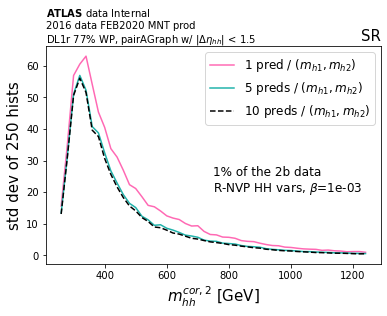

In [75]:
plt.plot(xx,std_1pred,color='hotpink',label='1 pred / $(m_{h1},m_{h2})$')
plt.plot(xx,std_5pred,color='lightseagreen',label='5 preds / $(m_{h1},m_{h2})$')
plt.plot(xx,hist_1sig,'k--',label='10 preds / $(m_{h1},m_{h2})$')
# Sanity check checked out lol
#plt.plot(xx,std_10pred,color='mediumorchid',label='10 preds / $(m_{h1},m_{h2})$ v2')

plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel(f'std dev of {250} hists',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(loc='upper right',fontsize=12)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.5, 0.45, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_std_250seeds_vary_nPreds.pdf', bbox_inches='tight')
plt.show()

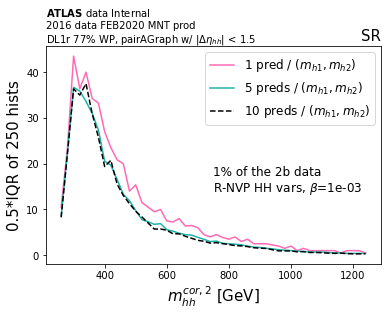

In [76]:
#plt.plot(xx,np.sqrt(n_2b),'k',label=r'$\sqrt{n_{2b}}$')

plt.plot(xx,0.5*iqr_1pred,color='hotpink',label='1 pred / $(m_{h1},m_{h2})$')
plt.plot(xx,0.5*iqr_5pred,color='lightseagreen',label='5 preds / $(m_{h1},m_{h2})$')
plt.plot(xx,0.5*iqr_p01,'k--',label='10 preds / $(m_{h1},m_{h2})$')

plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel(f'0.5*IQR of {250} hists',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(loc='upper right',fontsize=12)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.5, 0.45, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_iqr_250seeds_vary_nPreds.pdf', bbox_inches='tight')
plt.show()

**Take away**: If we use $\sigma$ instead of IQR, it seems like 5 predictions per sample is roughly enough to get smooth predictions with this sample size, although I might just use 10 to finish out this notebook for now lol.

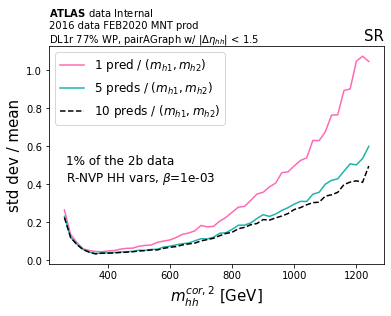

In [77]:
plt.plot(xx,std_1pred/nom_1pred,color='hotpink',label='1 pred / $(m_{h1},m_{h2})$')
plt.plot(xx,std_5pred/nom_5pred,color='lightseagreen',label='5 preds / $(m_{h1},m_{h2})$')
plt.plot(xx,hist_1sig/nom,'k--',label='10 preds / $(m_{h1},m_{h2})$')

plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel(f'std dev / mean',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(loc='upper left',fontsize=12)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.05, 0.5, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/relErrs_m_hh_cor2_SR_std_250seeds_vary_nPreds.pdf', bbox_inches='tight')
plt.show()

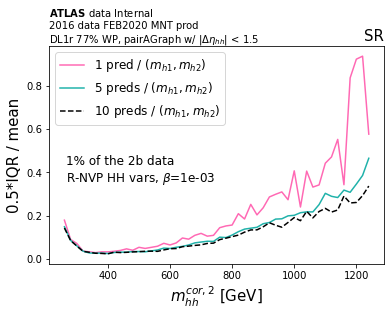

In [78]:
plt.plot(xx,0.5*iqr_1pred/nom_1pred,color='hotpink',label='1 pred / $(m_{h1},m_{h2})$')
plt.plot(xx,0.5*iqr_5pred/nom_5pred,color='lightseagreen',label='5 preds / $(m_{h1},m_{h2})$')
plt.plot(xx,0.5*iqr_p01/nom,'k--',label='10 preds / $(m_{h1},m_{h2})$')

plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel(f'0.5*IQR / mean',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(loc='upper left',fontsize=12)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.05, 0.5, f'{p*100:1.0f}% of the 2b data\nR-NVP {varTag}, {betaStr}={beta:1.0e}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/relErrs_m_hh_cor2_SR_iqr_250seeds_vary_nPreds.pdf', bbox_inches='tight')
plt.show()

### Probe the stability of the error bars w/r.t. how many model trainings I'm including

In [145]:
hists.shape

(250, 50)

In [79]:
for seed in range(nSeeds):

    S = seed+1
    k = f'p_{p}_beta{beta:.0e}'
    hists = np.vstack([r5Seeds_hists[f'{k}_seed{s}'] for s in range(S)])
    #print(hists.shape)

    r5Seeds_hists[f'{k}_{S}seeds_median'] = np.median(hists,axis=0)
    r5Seeds_hists[f'{k}_{S}seeds_mean']   =   np.mean(hists,axis=0)

    r5Seeds_hists[f'{k}_{S}seeds_IQR'] = iqr(hists,axis=0)
    r5Seeds_hists[f'{k}_{S}seeds_std'] = np.std(hists,axis=0)


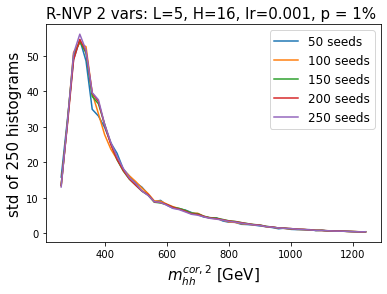

In [82]:
for S in np.arange(50,nSeeds+1,50):
    plt.plot(xx,r5Seeds_hists[f'{k}_{S}seeds_std'],label=f'{S} seeds')
    
plt.legend(fontsize=12)
plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel(f'std of {nSeeds} histograms',fontsize=15)
plt.title(title+', p = 1%',fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_std_vary_to_{nSeeds}seeds_10preds.pdf', bbox_inches='tight')

plt.show()

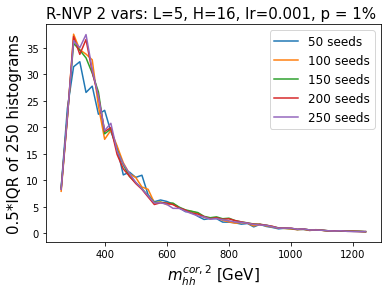

In [83]:
for S in np.arange(50,nSeeds+1,50):
    plt.plot(xx,0.5*r5Seeds_hists[f'{k}_{S}seeds_IQR'],label=f'{S} seeds')
    
plt.legend(fontsize=12)
plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel(f'0.5*IQR of {nSeeds} histograms',fontsize=15)
plt.title(title+', p = 1%',fontsize=15,loc='left')

plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_iqr_vary_to_{nSeeds}seeds_10preds.pdf', bbox_inches='tight')

plt.show()

Ok - so 250 seeds seems stable for the error bar here.

## Message plots for $m_{hh}^{cor,2}$ and $|\cos \Theta^*|$

Alright, let's take $1\sigma$ as the error band, and first just show the *marginals* for the HH variables.

In [84]:
x_fine = np.hstack([r[0]]+[ee for ee in e[1:-1] for i in range(2)]+[r[1]])

nom_fine = np.hstack([nn for nn in nj for i in range(2)])
sig_fine = np.hstack([nn for nn in hist_1sig for i in range(2)])

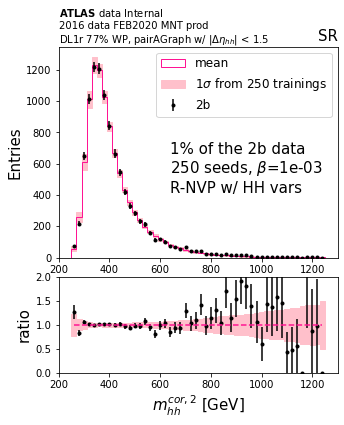

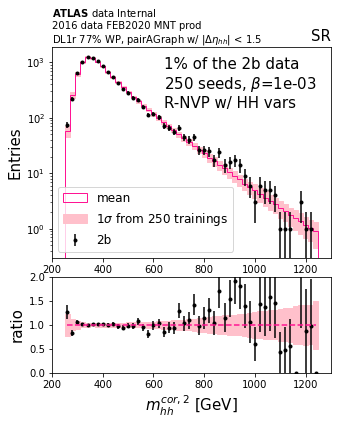

In [87]:
if varTag == 'HC vars':
    c0,c1 = 'thistle','darkviolet'
elif varTag == 'HH vars':
    c0,c1 = 'pink','deeppink'
else:
    print(f"Error: varTag = {varTag} not recognized")
    
for log, logTag,xloc,yloc in zip([False,True],['','_log'],[0.4, .4],[0.55,.95]):
    
    # Make the figure
    fig = plt.figure(figsize=(11,6))
    gs = gridspec.GridSpec(3,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

    # Error bars
    nj = nom
    ax1.fill_between(x_fine,nom_fine+sig_fine,nom_fine-sig_fine,
                     color=c0,label='$1\sigma$ from 250 trainings')
    ax2.fill_between(x_fine,(nom_fine+sig_fine)/nom_fine,(nom_fine-sig_fine)/nom_fine,color=c0)

    # 2b
    n_2b = r5Seeds_hists[f'p_{p}_2b']
    ax1.errorbar(xx, n_2b, np.sqrt(n_2b), label='2b', fmt='.', color='k')
    ax2.errorbar(xx, n_2b/nj, np.sqrt(n_2b)/nj, fmt='.', color='k',zorder=1)

    # Central value
    ax1.hist(xx,nb,r,color=c1,histtype='step',weights=nj,label='mean',log=log)
    ax2.plot(xx, np.ones_like(xx), color=c1,linestyle='--')

    ax1.set_ylabel('Entries',fontsize=15)
    ax1.legend(fontsize=12)
    ax1.set_title('SR',loc='right',fontsize=15)

    ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]', fontsize=15)
    ax2.set_ylim(0,2)
    ax2.set_ylabel('ratio',fontsize=15)

    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
    ax1.text(xloc,yloc, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}\nR-NVP w/ {varTag}',
             ha='left',va='top',transform=ax1.transAxes,fontsize=15)

    plt.savefig(f'{figDir_p01}/m_hh_cor2_SR_mean_1sigma_250seeds{logTag}.pdf', bbox_inches='tight')

plt.show()

Get the mean and error band for $|\cos \Theta^*|$

In [113]:
yy = 0.5*(f[1:]+f[:-1])

In [114]:
hists_cs = np.vstack([r5Seeds_hists_cs[f'p_{p}_beta{beta:.0e}_seed{s}'] for s in range(nSeeds)])

nom_cs = np.mean(hists_cs,axis=0)
std_cs = np.std(hists_cs,axis=0)

In [122]:
nom_cs_fine

array([  7.7364,   7.7364,  36.1692,  36.1692, 112.3616, 112.3616,
       202.3864, 202.3864, 253.9324, 253.9324, 272.6968, 272.6968,
       275.834 , 275.834 , 271.3616, 271.3616, 266.9612, 266.9612,
       263.1812, 263.1812, 260.4032, 260.4032, 258.0252, 258.0252,
       256.9688, 256.9688, 257.0872, 257.0872, 258.3752, 258.3752,
       260.8424, 260.8424, 264.6776, 264.6776, 270.6744, 270.6744,
       277.434 , 277.434 , 285.1092, 285.1092, 295.8568, 295.8568,
       307.2728, 307.2728, 320.28  , 320.28  , 332.1576, 332.1576,
       344.6368, 344.6368, 354.3532, 354.3532, 362.166 , 362.166 ,
       362.5156, 362.5156, 354.3056, 354.3056, 336.5404, 336.5404,
       307.578 , 307.578 , 271.8756, 271.8756, 234.5888, 234.5888,
       201.328 , 201.328 , 170.918 , 170.918 , 146.0988, 146.0988,
       124.3544, 124.3544, 106.1092, 106.1092,  90.086 ,  90.086 ,
        76.3576,  76.3576,  63.9708,  63.9708,  53.6968,  53.6968,
        44.468 ,  44.468 ,  36.4924,  36.4924,  29.5112,  29.5

In [125]:
sig_cs_fine

array([ 5.12511415,  5.12511415, 13.89005584, 13.89005584, 23.74775201,
       23.74775201, 24.77669984, 24.77669984, 20.15210238, 20.15210238,
       18.08145541, 18.08145541, 15.86283972, 15.86283972, 15.48437553,
       15.48437553, 13.3871003 , 13.3871003 , 11.7940191 , 11.7940191 ,
       11.85131173, 11.85131173, 11.64123554, 11.64123554, 12.3768165 ,
       12.3768165 , 12.64329689, 12.64329689, 12.9536877 , 12.9536877 ,
       12.78821185, 12.78821185, 12.23189839, 12.23189839, 12.59344213,
       12.59344213, 12.1501409 , 12.1501409 , 12.19994899, 12.19994899,
       12.35897301, 12.35897301, 12.92449071, 12.92449071, 13.1824368 ,
       13.1824368 , 13.71844752, 13.71844752, 13.78746988, 13.78746988,
       12.913491  , 12.913491  , 13.93532217, 13.93532217, 14.71246671,
       14.71246671, 16.38238959, 16.38238959, 18.08154661, 18.08154661,
       17.70097952, 17.70097952, 15.97415928, 15.97415928, 14.24774349,
       14.24774349, 13.78480671, 13.78480671, 12.76611907, 12.76

In [126]:
y_fine

array([ 0.   , -0.028, -0.028, -0.006, -0.006,  0.016,  0.016,  0.038,
        0.038,  0.06 ,  0.06 ,  0.082,  0.082,  0.104,  0.104,  0.126,
        0.126,  0.148,  0.148,  0.17 ,  0.17 ,  0.192,  0.192,  0.214,
        0.214,  0.236,  0.236,  0.258,  0.258,  0.28 ,  0.28 ,  0.302,
        0.302,  0.324,  0.324,  0.346,  0.346,  0.368,  0.368,  0.39 ,
        0.39 ,  0.412,  0.412,  0.434,  0.434,  0.456,  0.456,  0.478,
        0.478,  0.5  ,  0.5  ,  0.522,  0.522,  0.544,  0.544,  0.566,
        0.566,  0.588,  0.588,  0.61 ,  0.61 ,  0.632,  0.632,  0.654,
        0.654,  0.676,  0.676,  0.698,  0.698,  0.72 ,  0.72 ,  0.742,
        0.742,  0.764,  0.764,  0.786,  0.786,  0.808,  0.808,  0.83 ,
        0.83 ,  0.852,  0.852,  0.874,  0.874,  0.896,  0.896,  0.918,
        0.918,  0.94 ,  0.94 ,  0.962,  0.962,  0.984,  0.984,  1.006,
        1.006,  1.028,  1.028,  1.   ])

In [127]:
y_fine = np.hstack([-0.05]+[ee for ee in f[1:-1] for i in range(2)]+[1.05])

nom_cs_fine = np.hstack([nn for nn in nom_cs for i in range(2)])
sig_cs_fine = np.hstack([nn for nn in std_cs for i in range(2)])

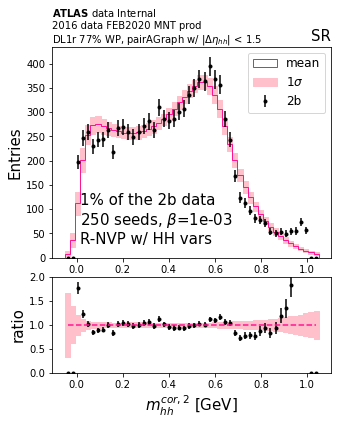

In [128]:
# Make the figure
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

# # Error bars
ax1.fill_between(y_fine,nom_cs_fine+sig_cs_fine,nom_cs_fine-sig_cs_fine,
                 color=c0,label='$1\sigma$')
ax2.fill_between(y_fine,(nom_cs_fine+sig_cs_fine)/nom_cs_fine,
                 (nom_cs_fine-sig_cs_fine)/nom_cs_fine,color=c0)

# 2b
n_2b_cs = r5Seeds_hists_cs[f'p_{p}_2b']
ax1.errorbar(yy, n_2b_cs, np.sqrt(n_2b_cs), label='2b', fmt='.', color='k')
ax2.errorbar(yy, n_2b_cs/nom_cs, np.sqrt(n_2b_cs)/nom_cs, fmt='.', color='k',zorder=1)

# Central value
ax1.hist(yy, nb,(-0.05,1.05),color=c1,histtype='step',weights=nom_cs,label='mean')
ax2.plot(yy, np.ones_like(yy), color=c1,linestyle='--')

ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=12)
ax1.set_title('SR',loc='right',fontsize=15)

ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]', fontsize=15)
ax2.set_ylim(0,2)
ax2.set_ylabel('ratio',fontsize=15)

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
ax1.text(0.1, 0.05, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}\nR-NVP w/ {varTag}',
         ha='left',va='bottom',transform=ax1.transAxes,fontsize=15)

plt.savefig(f'{figDir_p01}/absCosThetaStar_SR_mean_1sigma_250seeds.pdf', bbox_inches='tight')

plt.show()

**Next:** Split up the $m_{hh}^{cor,2}$ regions into 4 and compare the $m_{hh}$ shapes and errors

In [129]:
csb = [-0.05,.2,.4,.6,.8,1.05]

In [130]:
cs_all = df0['absCosThetaStar'].values.reshape(nSeeds,-1,nPreds)

In [131]:
nbi=25
ei = np.linspace(*r,nbi+1)
xxi = 0.5*(ei[1:]+ei[:-1])

xi_fine = np.hstack([r[0]]+[ee for ee in ei[1:-1] for i in range(2)]+[r[1]])

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


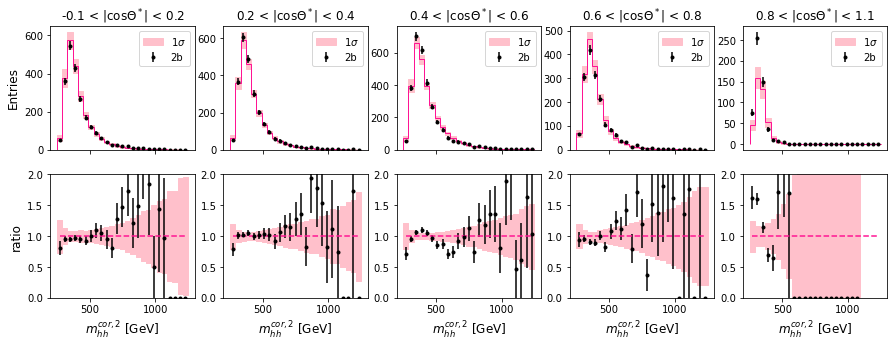

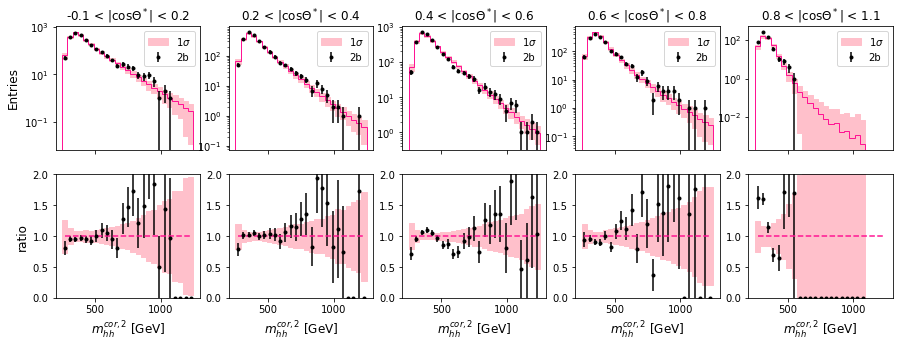

In [132]:
for log, logTag,xloc,yloc in zip([False,True],['','_log'],[0.4, .4],[0.55,.95]):

    fig, axes = plt.subplots(2,5,figsize=(15,5),sharex=True)
    ni_hist = []
    si_hist = []
    li_hist = []
    
    for cs_min,cs_max,axs in zip(csb[:-1],csb[1:],axes.T):

        ax1,ax2 = axs

        # Get 2b
        mask = SR & (df.absCosThetaStar > cs_min) & (df.absCosThetaStar < cs_max)
        n_2bi = np.histogram(df.loc[mask,'m_hh_cor2'],nbi,r)[0]
        ax1.errorbar(xxi, n_2bi, np.sqrt(n_2bi), label='2b', fmt='.', color='k')

        # Get the nominal estimate
        hs_10pred = np.zeros((nSeeds,nbi))
        for i in range(nSeeds):
            mi = (cs_all[i] > cs_min) & (cs_all[i] < cs_max)
            pi = np.histogram(mhh_all[i][mi],nbi,r)[0]
            hs_10pred[i] = pi / nPreds

        ni = np.mean(hs_10pred,axis=0)
        si = np.std(hs_10pred,axis=0)

        ni_fine = np.hstack([nn for nn in ni for i in range(2)])
        si_fine = np.hstack([nn for nn in si for i in range(2)])

        ax1.hist(xxi,nbi,r,weights=ni,color=c1,histtype='step',log=log)
        ax2.errorbar(xxi, n_2bi/ni, np.sqrt(n_2bi)/ni, fmt='.', color='k')

        ax1.fill_between(xi_fine,ni_fine+si_fine,ni_fine-si_fine,
                         color=c0,label='$1\sigma$')
        ax2.fill_between(xi_fine,(ni_fine+si_fine)/ni_fine,(ni_fine-si_fine)/ni_fine,color=c0)

        # Make the plot pretty
        l = f'{cs_min:.1f} < $|\cos \Theta^*|$ < {cs_max:.1f}'
        ax1.set_title(l,fontsize=12)
        ax2.plot(xxi,np.ones_like(xxi),color=c1,ls='--')
        ax2.set_xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=12)
        ax2.set_ylim((0,2))
        ax1.legend(loc='upper right')
        
        # Save info
        ni_hist.append(ni)
        si_hist.append(si)
        li_hist.append(l)
        
    axes[0,0].set_ylabel('Entries',fontsize=12)
    axes[1,0].set_ylabel('ratio',fontsize=12)

    plt.savefig(f'{figDir_p01}/m_hh_cor2_5_absCosThetaStar_bins_SR_mean{logTag}.pdf', bbox_inches='tight')

plt.show()

Last follow-up! Overlay the shape systs

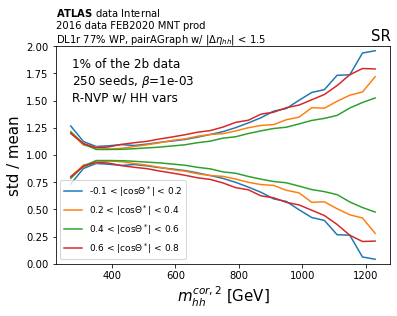

In [133]:
for ni,si,li,ci in zip(ni_hist,si_hist,li_hist,['C0','C1','C2','C3']):
    plt.plot(xxi,(ni+si)/ni,color=ci,label=li)
    plt.plot(xxi,(ni-si)/ni,color=ci)
    
plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
plt.ylabel('std / mean',fontsize=15)
plt.title('SR',loc='right',fontsize=15)
plt.legend(fontsize=9,loc='lower left')

plt.ylim(0,2)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.05, 0.95, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}\nR-NVP w/ {varTag}',
         ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir_p01}/m_hh_cor2_std_4_absCosThetaStar_bins_0-0.8_SR.pdf', bbox_inches='tight')